<a href="https://colab.research.google.com/github/rithikafjohnson/Covid-19-forecasting-using-lstm/blob/main/covid_forecasting_model_using_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM, Conv1D, Reshape, RepeatVector, TimeDistributed, MaxPooling1D, Flatten, Bidirectional
import matplotlib.pyplot as plt
seed = 7
np.random.seed(seed)

In [ ]:

data = pd.read_csv("Japancases1.csv")

In [ ]:
#def parse(x):
     
    #return pd.to_datetime(data['date'])

data = pd.read_csv('newIndiacases.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
data.index.name = 'date'
data.head()

,new_cases,new/total,growth_rate,total_cases
date,,,,
2020-01-30,1,1.000000,0.000000,1
2020-01-31,0,0.000000,-1.000000,1
2020-01-02,0,0.000000,0.000000,1
2020-02-02,1,0.500000,0.000000,2
2020-03-02,1,0.333333,-0.333333,3


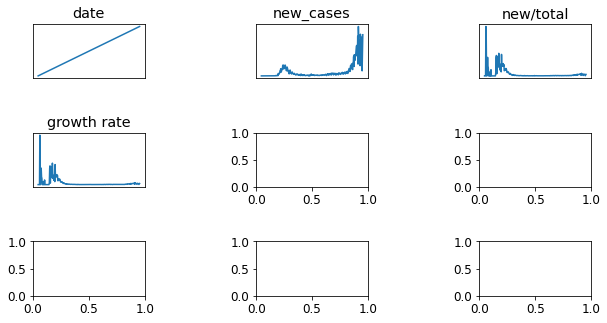

In [ ]:
groups = [0, 1, 2, 3]
values = data.values
fig,sub = plt.subplots(3,3)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(data.columns[i])

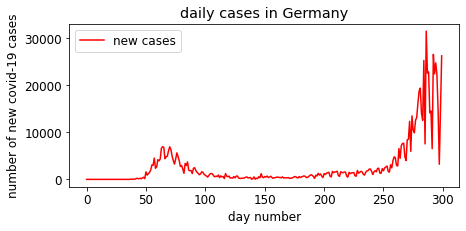

In [ ]:
#plt.plot(data['new/total'], label = "new/total",c = "b")
plt.plot(data['new_cases'][:200],label = "new cases",c="r")
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams.update({'font.size': 12})
plt.xlabel('day number')
plt.ylabel('number of new covid-19 cases')
plt.title("daily cases in Germany")
plt.legend()

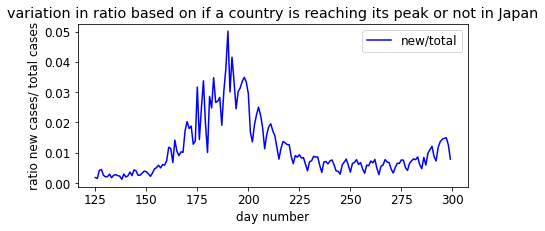

In [ ]:
plt.plot(data['new/total'][125:], label = "new/total",c = "b")
#plt.plot(data['new_cases'],label = "new cases",c="r")
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams.update({'font.size': 12})
plt.xlabel('day number')
plt.ylabel('ratio new cases/ total cases')
plt.title("variation in ratio based on if a country is reaching its peak or not in Japan")
plt.legend()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled[0]

array([2.41436256e-06, 1.00000000e+00, 5.59513769e-02, 0.00000000e+00])

In [ ]:
def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [ ]:
timeSteps = 28

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
0,0.000002,1.000000,0.055951,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.055951,0.000000e+00,0.000002,0.500000,0.055951,3.366968e-08,0.000002,0.333333,0.037301,6.733936e-08,0.000000,0.000000,0.000000,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,...,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000
1,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.055951,0.000000e+00,0.000002,0.500000,0.055951,3.366968e-08,0.000002,0.333333,0.037301,6.733936e-08,0.000000,0.000000,0.000000,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,...,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000
2,0.000000,0.000000,0.055951,0.000000e+00,0.000002,0.500000,0.055951,3.366968e-08,0.000002,0.333333,0.037301,6.733936e-08,0.000000,0.000000,0.000000,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,...,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000
3,0.000002,0.500000,0.055951,3.366968e-08,0.000002,0.333333,0.037301,6.733936e-08,0.000000,0.000000,0.000000,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,...,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000
4,0.000002,0.333333,0.037301,6.733936e-08,0.000000,0.000000,0.000000,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,...,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.000000,0.055951,6.733936e-08,0.000000,0.

In [ ]:
features = data.shape[1]
train_hours = 448
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(448, 112) (28, 112) (448,) (28,)


In [ ]:
x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print(x_train.shape,x_test.shape)

(448, 28, 4) (28, 28, 4)


In [ ]:
'''model = Sequential()

model.add( Dense(1) )


model = Sequential()
model.add(Conv2D(25,(timeSteps//10,x_train.shape[2]) activation='relu'))
model.add(Conv2D(self.nb_filter, (self.kernel_size_x, self.kernel_size_y), input_shape=self.input_shape, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2))) by imposing kernel_size_y to #features
model.add(Dropout(0.2))
model.add( LSTM( 50, input_shape = ( timeSteps,x_train.shape[2]) ) )
model.add(Dense(128, activation='relu'))
model.add(Dense(self.output_dim, activation='softmax'))
model.compile( loss = "mae", optimizer = "adam")

history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 500 , batch_size = 30, verbose = 1, shuffle = False)'''

'model = Sequential()\n\nmodel.add( Dense(1) )\n\n\nmodel = Sequential()\nmodel.add(Conv2D(25,(timeSteps//10,x_train.shape[2]) activation=\'relu\'))\nmodel.add(Conv2D(self.nb_filter, (self.kernel_size_x, self.kernel_size_y), input_shape=self.input_shape, activation=\'relu\'))\n# model.add(MaxPool2D(pool_size=(2, 2))) by imposing kernel_size_y to #features\nmodel.add(Dropout(0.2))\nmodel.add( LSTM( 50, input_shape = ( timeSteps,x_train.shape[2]) ) )\nmodel.add(Dense(128, activation=\'relu\'))\nmodel.add(Dense(self.output_dim, activation=\'softmax\'))\nmodel.compile( loss = "mae", optimizer = "adam")\n\nhistory =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 500 , batch_size = 30, verbose = 1, shuffle = False)'

In [ ]:

!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  after removing the cwd from sys.path.


In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = ( timeSteps,x_train.shape[2])))
#model.add(layer = tf.keras.layers.Dropout(.2,))
model.add(tf.keras.layers.GRU(30,return_sequences=False))
model.add(tf.keras.layers.Dropout(.2,))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate=0.003))

In [ ]:
'''model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=( timeSteps,x_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')'''

"model = Sequential()\nmodel.add(LSTM(50, activation='relu', input_shape=( timeSteps,x_train.shape[2])))\nmodel.add(Dense(1))\nmodel.compile(optimizer='adam', loss='mse')"

In [ ]:
'''model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=( timeSteps,x_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')'''

"model = Sequential()\nmodel.add(Bidirectional(LSTM(50, activation='relu'), input_shape=( timeSteps,x_train.shape[2])))\nmodel.add(Dense(1))\nmodel.compile(optimizer='adam', loss='mse')"

In [ ]:
history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 100 , batch_size = 16, verbose = 1, shuffle = False)

Epoch 1/100
28/28 [==============================] - 4s 45ms/step - loss: 0.0429 - val_loss: 0.0229
Epoch 2/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0140 - val_loss: 0.0956
Epoch 3/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0118 - val_loss: 0.0525
Epoch 4/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0189 - val_loss: 0.0801
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0130 - val_loss: 0.0814
Epoch 6/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0143 - val_loss: 0.0322
Epoch 7/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0209 - val_loss: 0.0018
Epoch 8/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0361 - val_loss: 0.0347
Epoch 9/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0355 - val_loss: 0.0103
Epoch 10/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0094 - val_loss: 0.1351

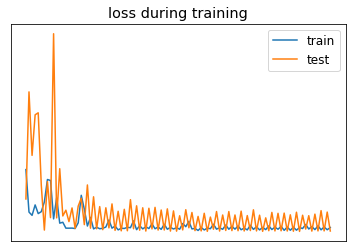

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 12})
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

In [ ]:
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])
forecast_copies = np.repeat(y_pred, 3, axis=-1)
inv_new = np.concatenate( (y_pred,x_test[:,0:3]  ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)[:,0]
final_pred = inv_new


y_test = y_test.reshape( len(y_test), 1)
forecast_copies = np.repeat(y_test, 3, axis=-1)
inv_new = np.concatenate( (y_test,x_test[:,0:3]  ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

In [ ]:
actual_pred , final_pred

(array([259551., 257299., 240842., 222315., 196427., 208921., 211298.,
        186364., 173790., 165553., 152734., 127510., 132788., 134154.,
        132364., 120529., 114460., 100636.,  86498.,  92596.,  93463.,
         92291.,  84332.,  80834.,  70421.,  60471.,  62224.,  67208.]),
 array([239349.63863087, 225113.57525778, 228142.24126768, 212499.53188944,
        200869.78028679, 179666.97040248, 191867.94204211, 190621.81434798,
        172314.60469437, 164633.00610471, 156857.95287549, 146620.41741753,
        126551.59212863, 130373.45608902, 130248.85813212, 130244.21687675,
        121703.86260438, 117360.166008  , 106051.59915257,  94578.65038788,
         97604.93405128,  98290.65484595,  98485.87765032,  93069.23020113,
         90277.07688719,  81997.52166706,  73639.37369961,  73326.90364999]))

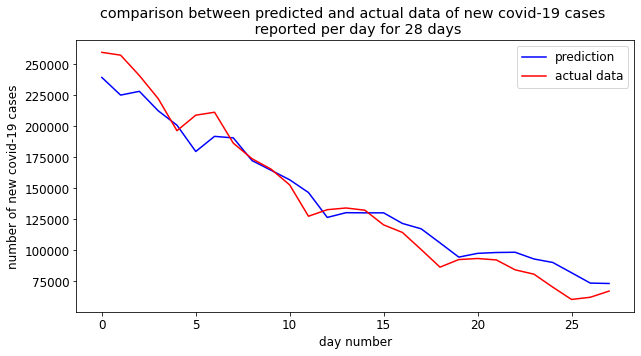

In [ ]:
plt.plot(final_pred, label = "prediction",c = "b")
plt.plot(actual_pred,label = "actual data",c="r")
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams.update({'font.size': 12})
plt.xlabel('day number')
plt.ylabel('number of new covid-19 cases')
plt.title("comparison between predicted and actual data of new covid-19 cases \n reported per day for 28 days")
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print("means abs error" ,mean_absolute_error(final_pred,actual_pred))
print("mse" ,mean_squared_error(final_pred,actual_pred))

means abs error 11454.129141809683
mse 202040570.69776657


In [ ]:
from sklearn.utils.validation import check_array as check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(final_pred,actual_pred)

8.873651173567158

In [ ]:
model.save_weights('covid 5.58.h5')

In [ ]:
a= [259551., 257299., 240842., 222315., 196427., 208921., 211298.,
        186364., 173790., 165553., 152734., 127510., 132788., 134154.,
        132364., 120529., 114460., 100636.,  86498.,  92596.,  93463.,
         92291.,  84332.,  80834.,  70421.,  60471.,  62224.,  67208.]
a=np.array(a)
f=[254337.78287554, 242010.21358919, 236554.98570466, 225926.46151233,
        214150.51036525, 198491.71706212, 197197.83134389, 193124.83349872,
        180052.84881842, 170696.76922572, 162511.34755218, 152934.53676617,
        138377.49848986, 134989.6536262 , 131059.60891545, 127735.60600078,
        121208.76656187, 116632.40235209, 109000.72194529, 100551.4955129 ,
         99416.75177598,  97401.86061281,  95972.74895662,  92051.14120877,
         89380.95662993,  83841.88989824,  77979.23755717,  76055.12860858]
f=np.array(f)

In [ ]:
mean_absolute_percentage_error(f,a)

8.596508942959877